In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train_path = "/Users/sailaharimullapudi/Desktop/kneeKL224Sample/train"
test_path = "/Users/sailaharimullapudi/Desktop/kneeKL224Sample/test"
valid_path = "/Users/sailaharimullapudi/Desktop/kneeKL224Sample/val"
list_of_classes = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
import os
import pandas as pd

for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels = [] 
    classlist = os.listdir(d)
    
    for klass in classlist:
        try:
            intklass = int(klass)
            label = list_of_classes[intklass]
            classpath = os.path.join(d, klass)
            flist = os.listdir(classpath)        
            
            for f in flist:
                fpath = os.path.join(classpath, f)
                filepaths.append(fpath)
                labels.append(label)
        
        except ValueError:
            # Skip directories that are not valid integers
            continue
    
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')        
    pdf = pd.concat([Fseries, Lseries], axis=1)
    
    if d == test_path:
        test_df = pdf
    elif d == valid_path:
        valid_df = pdf
    else:
        train_df = pdf

print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# get the number of classes and the images count for each class in train_df
classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist = []
classlist = []
for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# lets get the average height and width of a sample of the train images
ht = 0
wt = 0

train_df_sample = train_df.sample(n = 100, random_state = 123, axis = 0)
for i in range (len(train_df_sample)):
    fpath = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]

train_df length:  100   test_df length:  100   valid_df length:  100
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                 20      
           Healthy                  20      
           Minimal                  20      
           Moderate                 20      
            Severe                  20      


In [3]:
# image size - avg hight and width
average_height = ht // 100
average_width = wt // 100
image_size = (average_height, average_width)

# preprocess images
def preprocess(filepaths):
    images = []
    for filepath in filepaths:
        img = plt.imread(filepath)
        img = resize(img, image_size, anti_aliasing=True)
        img_flat = img.flatten()
        images.append(img_flat)
    return images

In [4]:
train_images = preprocess(train_df['filepaths'])
test_images = preprocess(test_df['filepaths'])
valid_images = preprocess(valid_df['filepaths'])

In [10]:
# label encoding 
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['labels'])
test_labels = label_encoder.transform(test_df['labels'])
valid_labels = label_encoder.transform(valid_df['labels'])


print(train_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(train_images, train_labels)
testrf_predictions = rf.predict(test_images)

accuracy = accuracy_score(test_labels, testrf_predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(test_labels, testrf_predictions, target_names=list_of_classes))

Accuracy: 0.23
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.18      0.30      0.22        20
    Doubtful       0.30      0.35      0.33        20
     Minimal       0.21      0.20      0.21        20
    Moderate       0.00      0.00      0.00        20
      Severe       0.40      0.30      0.34        20

    accuracy                           0.23       100
   macro avg       0.22      0.23      0.22       100
weighted avg       0.22      0.23      0.22       100



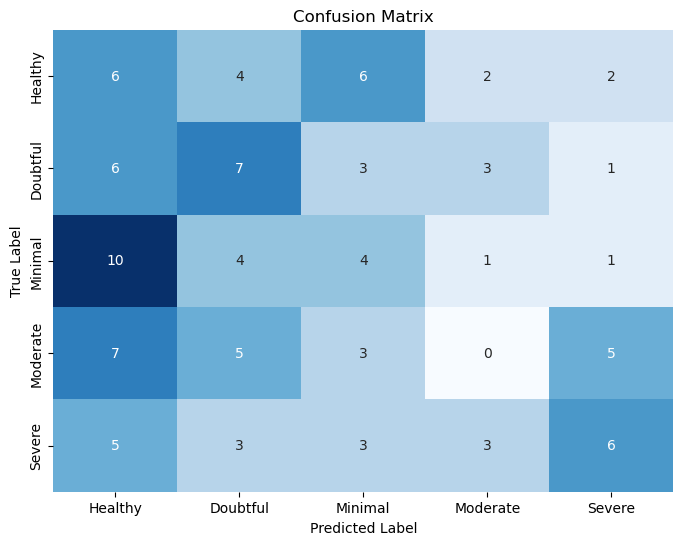

In [8]:
matrix = confusion_matrix(test_labels, testrf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap = "Blues", fmt="d", cbar=False,
            xticklabels=list_of_classes, yticklabels=list_of_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

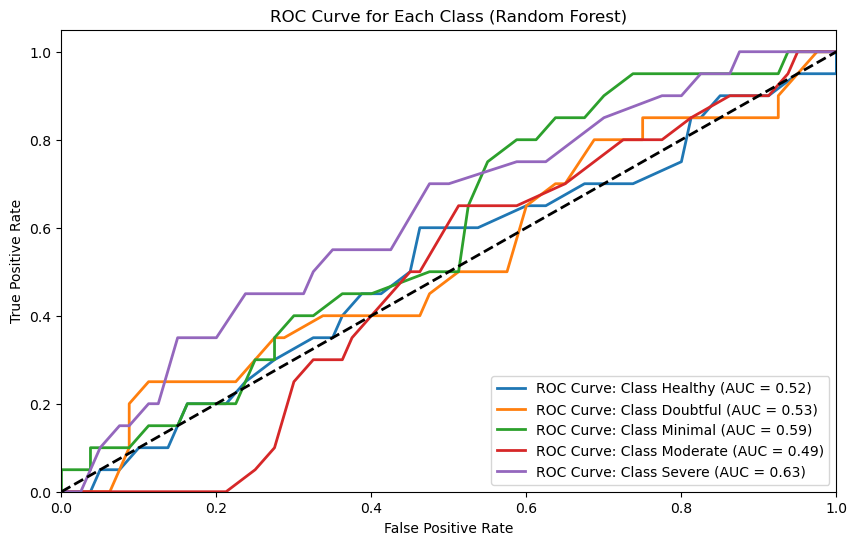

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

rf_decision_function = rf.predict_proba(test_images)
test_labels_binary = label_binarize(test_labels, classes=np.unique(train_labels))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(train_labels))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], rf_decision_function[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(np.unique(train_labels))):
    x = ""
    if i == 0:
        x = "Healthy"
    elif i == 1:
        x = "Doubtful"
    elif i == 2:
        x = "Minimal"
    elif i == 3:
        x = "Moderate"
    else:
        x = "Severe"
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC Curve: Class {} (AUC = {:.2f})'.format(x, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Random Forest)')
plt.legend(loc='lower right')
plt.show()
